In [1]:
# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# read fetal supp data
pre_adata_supp1 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190319_fetal_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# read adult supp data
pre_adata_supp2 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_adult_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# merge with raw
pre_adata = pd.concat([pre_adata, pre_adata_supp1,pre_adata_supp2], axis=1)
cell_names = pre_adata.columns.tolist()

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_mel_metadata.csv')
meta_df = meta_df.drop(['GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

# add bsc data:
bsc = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181106_bsc_metadata.csv')
merged_anno = pd.merge(meta_df,bsc,'left',['well','plate_barcode'])

# filter merged annotations
merged_anno = merged_anno[[x in cell_names for x in merged_anno.cell_name]]
merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), merged_anno, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')


scanpy version: 1.3.3


In [2]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo','ercc'], inplace=True)
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate_barcode':'plate',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'sample_color':'color',
             'patient_id':'patient',
             'bsc_a':'bsc'}
append_anno(raw_adata, merged_anno, anno_dict)
technical_filters(raw_adata)
raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 14370, Genes: 26577
Append annotations...
	Cells: 14370, Genes: 26577
Remove low-quality cells/genes...
	Initial:
	Cells: 14370, Genes: 26577
	Result:
	Cells: 10421, Genes: 24661
Remove ERCC genes...
Filtered genes: 89
	Cells: 10421, Genes: 24572


In [3]:
# create coarse age_groups and add ordered categories
reclass_dict = {'FET_12WK':'FET_12WK',
                 'NEO':'NEO',
                 '20_29':'20_49',
                 '30_39':'20_49',
                 '40_49':'20_49',
                 '50_59':'50_89',
                 '60_69':'50_89',
                 '80_89':'50_89'}
raw_adata.obs['age_group'] = (raw_adata
                                  .obs['age_bin']
                                  .map(reclass_dict))

ordered_groups_age_group = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
ordered_groups_age_bin = ['FET_12WK',
                 'NEO',
                 '20_29',
                 '30_39',
                 '40_49',
                 '50_59',
                 '60_69',
                 '80_89']

for class_name in ['age_bin','age_group']:
    raw_adata.obs[class_name] = (raw_adata
                                      .obs[class_name]
                                      .astype(str)
                                      .astype(CategoricalDtype(eval(f'ordered_groups_{class_name}'), ordered=True)))
    

... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


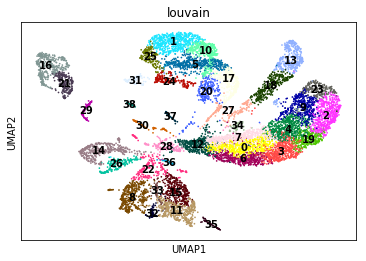

In [4]:
n_pcs = 25
# full_adata = process_adata(raw_adata)
full_adata = sc.pp.log1p(raw_adata, copy=True) # new
sc.pp.highly_variable_genes(full_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(full_adata) # new
sc.tl.pca(full_adata, use_highly_variable = True, n_comps=n_pcs) # new
sc.pp.neighbors(full_adata, n_pcs=n_pcs) # new
sc.tl.umap(full_adata, min_dist = 0.5)
sc.tl.louvain(full_adata, resolution = 2.2)
sc.pl.umap(full_adata, color=['louvain'], legend_loc='on data')
# pca_adata(full_adata, num_pcs=30)
# umap_adata(full_adata, res=0.1)

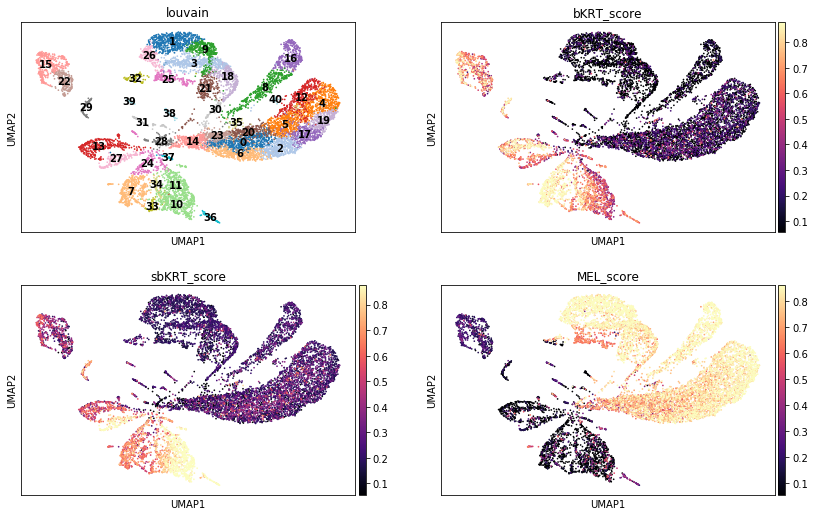

In [8]:
#SORT_module = ['ITGA6','KIT','ITGAX']
MEL_module = ['PMEL','TYR','DCT','MITF','TYRP1','SOX10']
bKRT_module = ['ITGB4','KRT14','KRT5','DSC3']
sbKRT_module = ['KRT1','KRT10','DSG1','DSC3']
cycling_module = ['TOP2A','CDK1','UBE2C','CDT1'] # ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf
## high = G2/M, low = G1/S

test_adata = full_adata
test_adata.obs['cell'] = test_adata.obs.index.tolist()
test_adata.obs['cell'] = (test_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(test_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(test_adata,
                 var_names = MEL_module+bKRT_module+sbKRT_module+cycling_module,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

test_adata.obs['MEL_score'] = exp_df.loc[:,MEL_module].mean(axis=1)
test_adata.obs['bKRT_score'] = exp_df.loc[:,bKRT_module].mean(axis=1)
test_adata.obs['sbKRT_score'] = exp_df.loc[:,sbKRT_module].mean(axis=1)
test_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)

sc.pl.umap(test_adata, color=['louvain','bKRT_score','sbKRT_score','MEL_score'], 
           ncols = 2, cmap = 'magma', palette = 'tab20', legend_loc = 'on data')

... storing 'class_1' as categorical


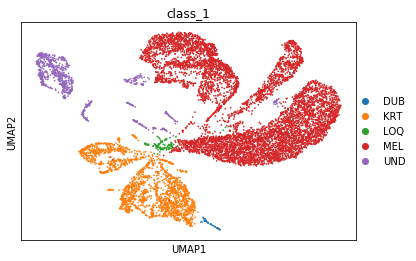

In [6]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,2,3,4,5,6,8,9,12,14,16,17,18,19,20,21,23,25,26,30,35,]
KRT_int = [7,10,11,13,24,27,33,34,36,37,]
DUB_int = [36]
LOQ_int = [28]
UND_int = [int(x) for x in list(set(input_adata.obs.louvain)) if not int(x) in MEL_int + KRT_int + DUB_int + LOQ_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int],
             'UND':[str(x) for x in UND_int],
             'DUB':[str(x) for x in DUB_int],
             'LOQ':[str(x) for x in LOQ_int]
            }

# add class_1 to raw
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

# add class_1 to full_adata
recip_type_dict = {}
for key,values in type_dict.items():
    for value in values:
        recip_type_dict[value] = key
        
input_adata.obs['class_1'] = input_adata.obs['louvain'].map(recip_type_dict)
sc.pl.umap(input_adata, color = 'class_1')


... storing 'cycling_cell' as categorical


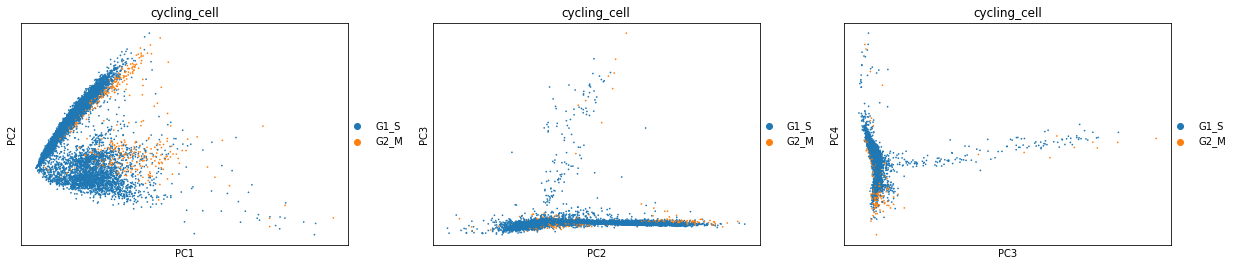

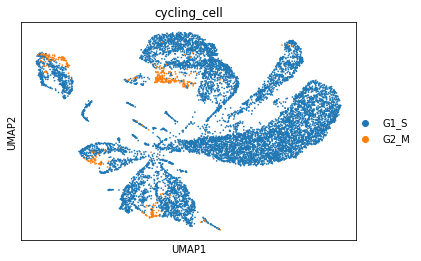

... storing 'class_1' as categorical


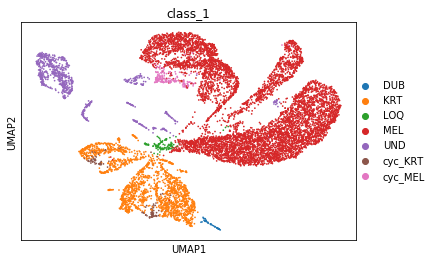

In [9]:
# cycling cell detection by adhoc cutoff
input_adata = full_adata
omit_names = []

omit_names = (input_adata[input_adata.obs.cycling_score > np.percentile(input_adata.obs.cycling_score.values, 95)]
              .obs
              .index
              .tolist()
             ) + omit_names

input_adata.obs['cycling_cell'] = ['G2_M' if x in set(omit_names) else 'G1_S' for x in input_adata.obs.index]

# cycling among adt-mels
sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_cell'])
sc.pl.umap(input_adata, color=['cycling_cell'], cmap='nipy_spectral')

# update class_1 labels with new "cycling" annotation
input_adata.obs['class_1'] = [f'cyc_{x}' if ((x == 'MEL' or x == 'KRT') and y == 'G2_M') else x for x,y in zip(input_adata.obs['class_1'], 
                                                                                                             input_adata.obs['cycling_cell'])]
    
sc.pl.umap(input_adata, color = 'class_1')

# update raw data with new class_1 labels
type_dict = {'KRT':['KRT'],
             'MEL':['MEL'],
             'UND':['UND'],
             'cycling':['cyc_MEL', 'cyc_KRT'],
             'DUB':['DUB'],
             'LOQ':['LOQ']
            }
classify_type(raw_adata, input_adata, 'class_1', type_dict, 'class_1')


In [112]:
# # MEL only
# n_pcs = 200
# feature_dict = {'class_1':['MEL']}
# adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
# # adata_subset1 = process_adata(adata_subset1)
# sc.pp.log1p(adata_subset1) # new
# sc.pp.highly_variable_genes(adata_subset1,min_mean=0.1,max_mean=10,min_disp=0.5) # new
# sc.pp.scale(adata_subset1) # new
# sc.tl.pca(adata_subset1, use_highly_variable = True, n_comps=n_pcs) # new
# sc.pp.neighbors(adata_subset1,n_pcs=n_pcs) # new
# sc.tl.umap(adata_subset1, min_dist = 0.5, )
# sc.tl.louvain(adata_subset1, resolution = 0.6)
# sc.pl.umap(adata_subset1, color=['louvain'], legend_loc='on data')
# # pca_adata(adata_subset1, num_pcs=10)
# # umap_adata(adata_subset1, res=0.15)

# test_adata = adata_subset1
# test_adata.obs['cell'] = test_adata.obs.index.tolist()
# test_adata.obs['cell'] = (test_adata
#                           .obs['cell']
#                           .astype(str)
#                           .astype(CategoricalDtype(test_adata.obs['cell'].tolist())))
# cat, exp_df = prepare_dataframe(test_adata,
#                  var_names = cycling_module,
#                  groupby = 'cell')
# exp_df = exp_df.rank(pct=True, axis=1, method = 'min')
# test_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)

# sc.pl.umap(test_adata, color = ['cycling_score'], ncols = 2)

In [113]:
# # initial PC coordinates
# cutoff = 10000
# input_adata = adata_subset1


# sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['louvain'])

# # cull cells using Tukey outlier threshold
# df = pd.DataFrame(input_adata.obsm['X_pca'])
# df.columns = ['PC_{}'.format(x) for x in range(n_pcs)]

# omit_names = []
# for pc in df.columns:
# #     print(len(set(omit_names)))
#     Q1 = df[pc].quantile(0.25)
#     Q3 = df[pc].quantile(0.75)
#     IQR = Q3 - Q1

#     bool_idx = [(Q1 - (cutoff * IQR)) > x or x > (Q3 + (cutoff * IQR)) for x in df[pc]]
#     filtered = df[bool_idx]
# #     print('Filtered cells: ', len(df)-len(filtered))
    
#     omit_names = omit_names + input_adata.obs[bool_idx].index.tolist()

# print('Filtered cells: ', len(set(omit_names)))

# # check where the outliers lie in original projection
# input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# # outliers among adt-mels
# sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['outliers'])
# sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# # outliers on all-cells projection
# # type_dict = {'ingroup':['ingroup'],
# #              'outlier':['outlier']}
    
# # classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')
# # sc.pl.umap(full_adata, color = ['cycling_score'])


In [114]:
# # cycling MEL detection by adhoc cutoff
# input_adata = adata_subset1
# omit_names = []

# omit_names = (input_adata[input_adata.obs.cycling_score > np.percentile(input_adata.obs.cycling_score.values, 95)]
#               .obs
#               .index
#               .tolist()
#              ) + omit_names

# input_adata.obs['cycling_MEL'] = [x in set(omit_names) for x in input_adata.obs.index]

# # cycling among adt-mels
# sc.pl.pca(input_adata, components=['1,2', '2,3','3,4'], color=['cycling_MEL'])
# sc.pl.umap(input_adata, color=['cycling_MEL'], cmap='nipy_spectral')

# # update cycling MELs in all adata objs
# type_dict = {False:[False],
#              True:[True]}

# for target_adata in [raw_adata, full_adata]:
#     classify_type(target_adata, input_adata, 'cycling_MEL', type_dict, 'cycling_MEL')
# #     sc.pl.umap(input_adata, color = ['cycling_score'])


In [115]:
# # maximize mean cycling score
# results = []
# threshold_list = []
# fraction_removed = []
# for x in tqdm.tqdm(range(10,101,2)):
#     # cull cells using Tukey outlier threshold
#     df = pd.DataFrame(test_adata.obsm['X_pca'])
#     df.columns = ['PC_{}'.format(x) for x in range(n_pcs)]
    
#     threshold=x/10
#     threshold_list.append(threshold)
    
#     omit_names = []
#     for pc in df.columns:
#     #     print(len(set(omit_names)))
#         Q1 = df[pc].quantile(0.25)
#         Q3 = df[pc].quantile(0.75)
#         IQR = Q3 - Q1

#         bool_idx = [(Q1 - (threshold * IQR)) > x or x > (Q3 + (threshold * IQR)) for x in df[pc]]
#         omit_names = omit_names + test_adata.obs[bool_idx].index.tolist()
    
#     omit_names = list(set(omit_names))    
#     fraction_removed.append(len(omit_names)/len(df))
    
#     # check where the outliers lie in original projection
#     cell_bool = [x in set(omit_names) for x in test_adata.obs.index]
#     score_vec = test_adata[cell_bool].obs.sort_values('cycling_score', ascending = False)['cycling_score'].values
#     results.append(score_vec.mean())
    
# results_df = pd.DataFrame({'threshold':threshold_list,
#                            'mean_score':results,
#                            'fraction_removed':fraction_removed
#                           })

# cutoff = results_df[results_df.mean_score == results_df.mean_score.max()]['threshold'].values[0]
# print('cutoff:', cutoff)


key = class_1, value = MEL, matched = 7170
	Cells: 7170, Genes: 24572


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


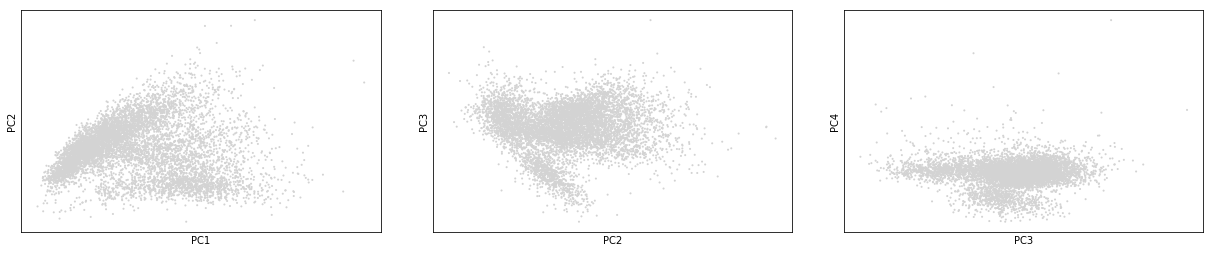

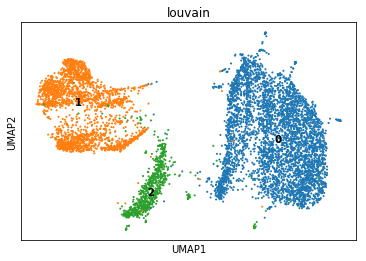

In [10]:
n_pcs = 150

feature_dict = {'class_1':['MEL']}
adata_subset2 = subset_adata_v3(raw_adata,feature_dict)
sc.pp.log1p(adata_subset2) # new
sc.pp.highly_variable_genes(adata_subset2,min_mean=0.5,max_mean=10,min_disp=0.5) # new
sc.pp.scale(adata_subset2) # new
sc.tl.pca(adata_subset2, use_highly_variable = True, n_comps=n_pcs) # new
sc.pl.pca(adata_subset2, components=['1,2', '2,3','3,4'])
sc.pp.neighbors(adata_subset2,n_pcs=n_pcs) # new
sc.tl.umap(adata_subset2, min_dist = 0.25)
sc.tl.louvain(adata_subset2, resolution = 0.2)
sc.pl.umap(adata_subset2, color=['louvain'], legend_loc='on data')
# pca_adata(adata_subset2, num_pcs=30)
# umap_adata(adata_subset2, res=0.15)


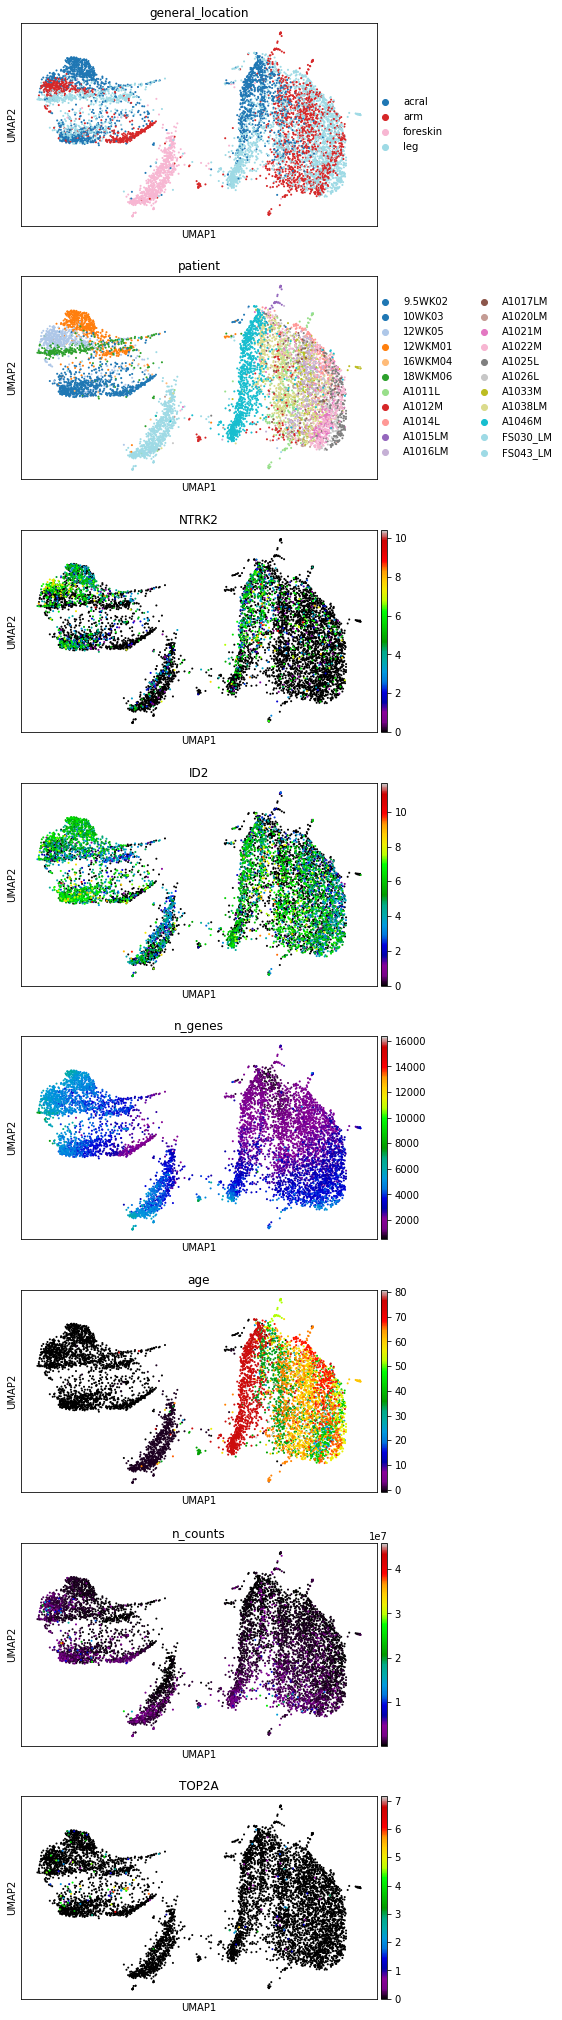

In [11]:
# sanity check

sc.pl.umap(adata_subset2, color = ['general_location','patient','NTRK2','ID2','n_genes','age','n_counts','TOP2A'], 
           palette = 'tab20', ncols = 1, cmap = 'nipy_spectral')


In [118]:
# # calculate txn noise
# input_adata = adata_subset2
# groupby = ['patient','anatomical_location']
# features_df = (input_adata.obs.loc[:,groupby]
#                .drop_duplicates()
#                .reset_index()
#                .drop('index', axis = 1))

# noise_df = pd.DataFrame()
# for row in range(len(features_df)):
#     feature_slice = pd.DataFrame(features_df.iloc[row,:]).T
#     filtered_adata = input_adata
#     noise_group = []
#     for col in feature_slice.columns:
#         feature_match = feature_slice[col].values[0]
#         filtered_adata = filtered_adata[filtered_adata.obs[col] == feature_match]
#         noise_group.append(feature_match)

#     cell_list = filtered_adata.obs.index.tolist()
#     noise_slice = txn_noise_spearman(cell_list, pre_adata)
#     noise_slice['noise_group'] = '_'.join(noise_group)
#     noise_df = noise_df.append(noise_slice)

# # update adata
# ordered_noise = pd.merge(pd.DataFrame({'cell':adata_subset2.obs.index}), noise_df, 'left', 'cell')
# adata_subset2.obs['agg_noise'] = ordered_noise.noise.values
# adata_subset2.obs['noise_group'] = ordered_noise.noise_group.values
    

key = class_1, value = KRT, matched = 1901
	Cells: 1901, Genes: 24572


... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


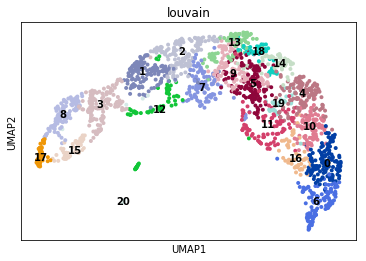

In [37]:
# krt only re-cluster
n_pcs = 4
feature_dict = {'class_1':['KRT']}
adata_subset1_KRT = subset_adata_v3(raw_adata,feature_dict)
# adata_subset1_KRT = process_adata(adata_subset1_KRT)
# pca_adata(adata_subset1_KRT, num_pcs=5)
# umap_adata(adata_subset1_KRT, res=0.2)
sc.pp.log1p(adata_subset1_KRT) # new
sc.pp.highly_variable_genes(adata_subset1_KRT) # new
sc.pp.scale(adata_subset1_KRT) # new
sc.tl.pca(adata_subset1_KRT, use_highly_variable = True, n_comps=n_pcs) # new
# sc.pl.pca(adata_subset1_KRT, components=['1,2', '2,3','3,4'])
sc.pp.neighbors(adata_subset1_KRT,n_pcs=n_pcs) # new
sc.tl.umap(adata_subset1_KRT, min_dist = 0.2, )
sc.tl.louvain(adata_subset1_KRT, resolution = 2)
sc.pl.umap(adata_subset1_KRT, color=['louvain'], legend_loc='on data')


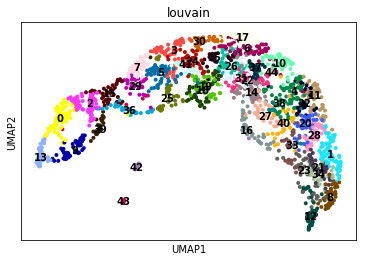

In [41]:
sc.tl.umap(adata_subset1_KRT, min_dist = 0.2, )
sc.tl.louvain(adata_subset1_KRT, resolution = 5)
sc.pl.umap(adata_subset1_KRT, color=['louvain'], legend_loc='on data')

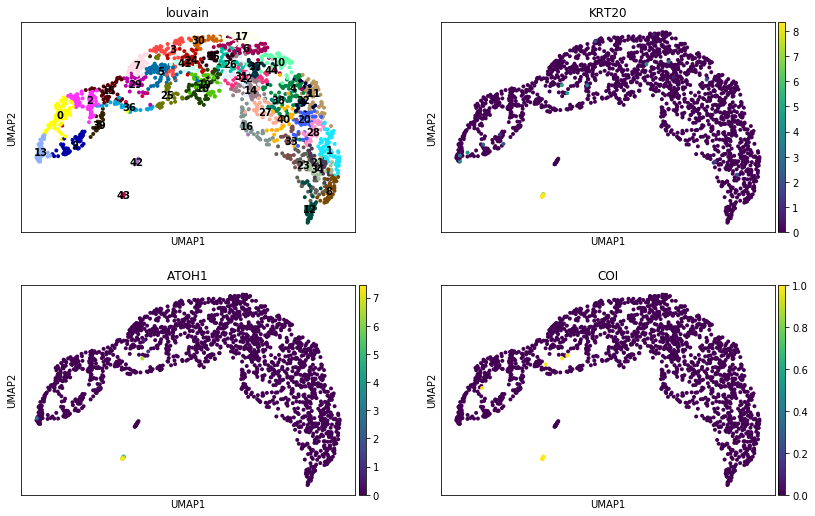

In [43]:
# sanity check

input_adata = adata_subset1_KRT
input_adata.obs['COI'] = [x == '43' for x in input_adata.obs.louvain]

sc.pl.umap(input_adata, color = ['louvain','KRT20','ATOH1','COI'], 
           ncols = 2,
           legend_loc = 'on data'   
          )


In [18]:
# pickle adatas
for objname in ['raw_adata','full_adata','adata_subset2','pre_adata','adata_subset1_KRT']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))

In [71]:
for objname in ['adata_subset2']:
    pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ) )
    syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
    subprocess.run(syscmd.split(' '))